In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier
import os
import gc
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
OriginDataDir = '/home/songyue/homeCredit/HomeCreditDefaultRisk/Data/OriginData'
TrainTestDataDir = '/home/songyue/homeCredit/HomeCreditDefaultRisk/Data/TrainTestData'
ModelSaveDir = '/home/songyue/homeCredit/HomeCreditDefaultRisk/Models/XGBoost/models'
ResultSaveDir = '/home/songyue/homeCredit/HomeCreditDefaultRisk/Models/XGBoost/result'

In [2]:
def loadData(DataName):
    DataPath = os.path.join(TrainTestDataDir, DataName)
    if not os.path.exists(DataPath):
        print('%s does not exist!' % DataPath)
        return
    OriginData = pd.read_csv(DataPath, index_col=0)
    #OriginData = OriginData.sample(frac=1)  # 打乱顺序后返回
    return OriginData


def NormalData(TrainData, TestData):
    # 对一些列的均值大于100的进行归一化处理
    AllData = TrainData.append(TestData)
    for col in AllData.columns:
        if abs(AllData[col].mean())>1:
            scaler = StandardScaler().fit(np.atleast_2d(AllData[col]).T)
            TrainData[col] = scaler.transform(np.atleast_2d(TrainData[col]).T)
    return TrainData

In [3]:
def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [4]:
TestData = loadData('AllTest_withnull.csv')
TestID = TestData.SK_ID_CURR.values
TestData.drop('SK_ID_CURR', axis=1, inplace=True)
AllTrainData = loadData('AllTrain_withnull.csv')
AllTrainData.reset_index(drop=True, inplace=True)
AllTrainData.drop('SK_ID_CURR', axis=1, inplace=True)

In [5]:
AllTrainData.shape

(307511, 1244)

In [51]:
TestData.shape

(48744, 1243)

In [52]:
features = [x for x in AllTrainData.columns if x != 'TARGET' and x != 'SK_ID_CURR']

In [53]:
len(features)

1243

In [54]:
lgbm_params = {
    "boosting":"dart",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':0.041545473,
    'reg_lambda': 0.0735294,
    "n_estimators":10000,
    "max_depth":8,
    "num_leaves":34,
    "max_bin":225,
    "colsample_bytree":0.9497036,
    "subsample":0.8715623,
    "min_split_gain":0.0222415,
    "min_child_weight":39.3259775
}

In [55]:
model = lgb.LGBMClassifier(application="binary", boosting_type=lgbm_params["boosting"],
                          learning_rate=lgbm_params["learning_rate"],n_estimators=lgbm_params["n_estimators"],
                          num_leaves=lgbm_params["num_leaves"], max_depth=lgbm_params["max_depth"],
                          max_bin=lgbm_params["max_bin"], num_threads =-1,colsample_bytree=lgbm_params["colsample_bytree"],
                          subsample=lgbm_params["subsample"],min_split_gain=lgbm_params["min_split_gain"],
                          min_child_weight=lgbm_params["min_child_weight"])
#                           min_data_in_leaf=lgbm_params["min_data_in_leaf"],
#                            feature_fraction=lgbm_params["feature_fraction"],

In [56]:
feature_importances = np.zeros(len(features))
for i in range(2):
    train_data, test_data, train_y, test_y = train_test_split(AllTrainData[features],AllTrainData['TARGET']
                                                              ,test_size=0.2, random_state=i)
    model.fit(train_data, train_y, early_stopping_rounds=200, 
              eval_set=[(test_data, test_y)], eval_metric='auc', verbose=200)
    feature_importances += model.feature_importances_   

Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.783095
[400]	valid_0's auc: 0.791754
[600]	valid_0's auc: 0.793677
[800]	valid_0's auc: 0.793848
Early stopping, best iteration is:
[696]	valid_0's auc: 0.79454
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.789041
[400]	valid_0's auc: 0.797766
[600]	valid_0's auc: 0.798475
Early stopping, best iteration is:
[502]	valid_0's auc: 0.799117


In [57]:
feature_importances = feature_importances/2
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head(30)

,feature,importance
49,EXT_SOURCE_MEAN,562.5
785,NEW_CREDIT_TO_GOODS_RATIO,292.5
876,EXT_SOURCE_gap,192.0
784,NEW_CREDIT_TO_ANNUITY_RATIO,184.5
54,EXT_SOURCE_PROD,175.5
843,DEBT_CREDIT_RATIO_new,167.5
10,DAYS_BIRTH,154.0
353,AMT_PAYMENT_minus_mean_mean,146.5
33,EXT_SOURCE_3,146.5
892,EXT_SOURCE_nanmedian,143.0


In [15]:
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail(32)

There are 196 features with 0.0 importance


,feature,importance
553,CNT_DRAWINGS_ATM_CURRENT_min_max,0.0
551,CNT_DRAWINGS_OTHER_CURRENT_max_max,0.0
550,CNT_DRAWINGS_OTHER_CURRENT_max_mean,0.0
547,CNT_DRAWINGS_OTHER_CURRENT_min_max,0.0
546,CNT_DRAWINGS_OTHER_CURRENT_min_mean,0.0
541,CNT_DRAWINGS_POS_CURRENT_min_max,0.0
537,NAME_CONTRACT_STATUS_Signed_sum_max,0.0
158,ORGANIZATION_TYPE_Industry: type 12,0.0
535,NAME_CONTRACT_STATUS_Sent proposal_sum_max,0.0
534,NAME_CONTRACT_STATUS_Sent proposal_sum_mean,0.0


In [58]:
def plot_feature_importances(df, threshold=0.98):
    
    plt.rcParams["font.size"] = 20
    
    df = df.sort_values('importance', ascending=False).reset_index()
    
    df['importance_normalized'] = df['importance']/df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.figure(figsize=(10,10))
    ax = plt.subplot()
    
    ax.barh(list(reversed(list(df.index[:30]))),
            df['importance_normalized'].head(30),
            align='center', edgecolor='k')
    ax.set_yticks(list(reversed(list(df.index[:30]))))
    ax.set_yticklabels(df['feature'].head(30))
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    plt.figure(figsize=(8,6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of features');plt.ylabel('Cumulative Importances');
    
    plt.title("Cumulative Feature Importance");
    plt.show()
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

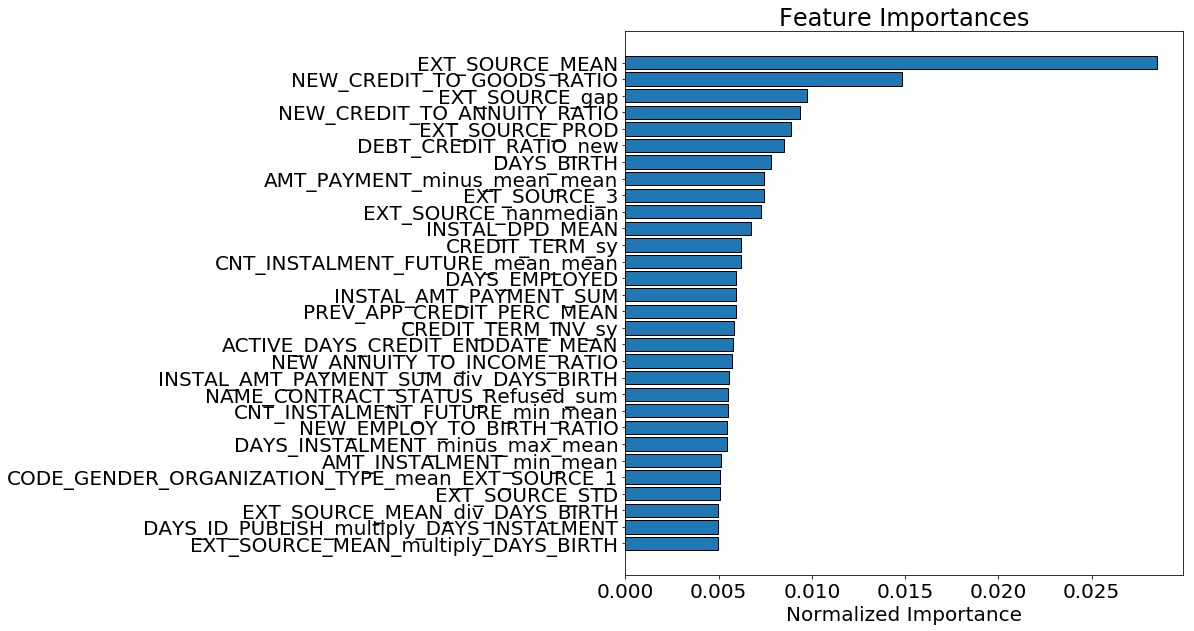

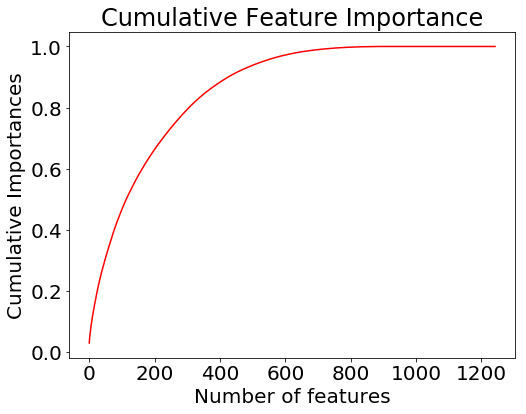

638 features required for 0.98 of cumulative importance


In [59]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [63]:
threshold = 0.99

features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])


In [64]:
print('Training shape: ', data.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 1243)
Testing shape:  (48744, 1243)


In [65]:
data = AllTrainData[features_to_keep]
test  = TestData[features_to_keep]

In [66]:
n_folds = 5
k_fold = KFold(n_splits=n_folds, shuffle=False, random_state=47)

feature_importances_values = np.zeros(data.shape[1])

test_predictions = np.zeros(test.shape[0])
out_of_fold = np.zeros(data.shape[0])

valid_scores = []
train_scores = []

for train_indices, test_indices in k_fold.split(data):
    
    train_data, train_y = AllTrainData[features].iloc[train_indices], AllTrainData.TARGET.iloc[train_indices]
    test_data, test_y = AllTrainData[features].iloc[test_indices], AllTrainData.TARGET.iloc[test_indices]
    
    model = lgb.LGBMClassifier(application="binary", boosting_type=lgbm_params["boosting"],
                          learning_rate=lgbm_params["learning_rate"],n_estimators=lgbm_params["n_estimators"],
                          num_leaves=lgbm_params["num_leaves"], max_depth=lgbm_params["max_depth"],
                          max_bin=lgbm_params["max_bin"], num_threads =-1,colsample_bytree=lgbm_params["colsample_bytree"],
                          subsample=lgbm_params["subsample"],min_split_gain=lgbm_params["min_split_gain"],
                          min_child_weight=lgbm_params["min_child_weight"])
    
    model.fit(train_data, train_y, eval_metric='auc', eval_set=[(test_data, test_y), (train_data, train_y)],
              eval_names=['valid', 'train'], early_stopping_rounds=200, verbose=200)
    
    best_iteration = model.best_iteration_
    feature_importances_values += model.feature_importances_ / k_fold.n_splits
    
    test_predictions += model.predict_proba(test, num_iteration=best_iteration)[:,1]/k_fold.n_splits
    
    out_of_fold[test_indices] = model.predict_proba(test_data, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
    valid_score = model.best_score_['valid']['auc']
    train_score = model.best_score_['train']['auc']
        
    valid_scores.append(valid_score)
    train_scores.append(train_score)
        
    gc.enable()
    del model, train_data, test_data
    gc.collect()

Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.817483	valid's auc: 0.779969
[400]	train's auc: 0.848505	valid's auc: 0.788829
[600]	train's auc: 0.870461	valid's auc: 0.789829
Early stopping, best iteration is:
[539]	train's auc: 0.867166	valid's auc: 0.790237
Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.816631	valid's auc: 0.78219
[400]	train's auc: 0.847456	valid's auc: 0.792096
[600]	train's auc: 0.869838	valid's auc: 0.793992
[800]	train's auc: 0.886743	valid's auc: 0.794828
[1000]	train's auc: 0.901869	valid's auc: 0.794873
Early stopping, best iteration is:
[891]	train's auc: 0.894511	valid's auc: 0.795376
Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.817856	valid's auc: 0.773235
[400]	train's auc: 0.848528	valid's auc: 0.783426
[600]	train's auc: 0.870492	valid's auc: 0.78618
[800]	train's auc: 0.887897	valid's auc: 0.786408


KeyboardInterrupt: 

In [34]:
submission = pd.DataFrame({'SK_ID_CURR': TestID, 'TARGET': test_predictions})
submission.to_csv("submissions_lgbm.csv", index=False)

In [26]:
data.columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       ...
       '12_period_trend_SK_DPD', '12_period_trend_SK_DPD_DEF',
       '1_period_trend_SK_DPD', '1_period_trend_SK_DPD_DEF',
       '30_period_trend_SK_DPD', '30_period_trend_SK_DPD_DEF',
       '60_period_trend_SK_DPD', '60_period_trend_SK_DPD_DEF',
       '6_period_trend_SK_DPD', '6_period_trend_SK_DPD_DEF'],
      dtype='object', length=1099)

In [13]:
n_folds = 5
k_fold = KFold(n_splits=n_folds, shuffle=True, random_state=90210)

feature_importances_values = np.zeros(data.shape[1])

test_predictions = np.zeros((test.shape[0],n_folds))
out_of_fold = np.zeros(data.shape[0])

valid_scores = []
train_scores = []
count = 0
for train_indices, test_indices in k_fold.split(AllTrainData):
    
    train_data, train_y = AllTrainData[features].iloc[train_indices], AllTrainData.TARGET.iloc[train_indices]
    test_data, test_y = AllTrainData[features].iloc[test_indices], AllTrainData.TARGET.iloc[test_indices]
    
    model = lgb.LGBMClassifier(is_unbalance=False,
                               scale_pos_weight = 1,
                               reg_alpha=0.0,
                               reg_lambda=100,
                               min_split_gain=0.5,
                               colsample_bytree=0.05,
                               subsample_freq=1,
                               subsample=1.0,
                               min_child_samples=70,
                               num_leaves=30,
                               max_depth=-1,
                               max_bin=300,
                               learning_rate=0.02,
                               n_estimators=10000,
                               boosting_type='gbdt',
                               application="binary",
                              )
    
    model.fit(train_data, train_y, eval_metric='auc', eval_set=[(test_data, test_y), (train_data, train_y)],
              eval_names=['valid', 'train'], early_stopping_rounds=200, verbose=200)
    
    best_iteration = model.best_iteration_
    feature_importances_values += model.feature_importances_ / k_fold.n_splits
    
    test_predictions[:,count] = model.predict_proba(test, num_iteration=best_iteration)[:,1]/k_fold.n_splits
    count+=1
    out_of_fold[test_indices] = model.predict_proba(test_data, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
    valid_score = model.best_score_['valid']['auc']
    train_score = model.best_score_['train']['auc']
        
    valid_scores.append(valid_score)
    train_scores.append(train_score)
        
    gc.enable()
    del model, train_data, test_data
    gc.collect()

Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.789297	valid's auc: 0.770258
[400]	train's auc: 0.805991	valid's auc: 0.779544
[600]	train's auc: 0.817681	valid's auc: 0.784025
[800]	train's auc: 0.82728	valid's auc: 0.786615
[1000]	train's auc: 0.835656	valid's auc: 0.788327
[1200]	train's auc: 0.843163	valid's auc: 0.789474
[1400]	train's auc: 0.849747	valid's auc: 0.79027
[1600]	train's auc: 0.855906	valid's auc: 0.79071
[1800]	train's auc: 0.861596	valid's auc: 0.791101
[2000]	train's auc: 0.866824	valid's auc: 0.791421
[2200]	train's auc: 0.871856	valid's auc: 0.791688
[2400]	train's auc: 0.876464	valid's auc: 0.791804
[2600]	train's auc: 0.881077	valid's auc: 0.79198
[2800]	train's auc: 0.885335	valid's auc: 0.791987
[3000]	train's auc: 0.889297	valid's auc: 0.792067
[3200]	train's auc: 0.893157	valid's auc: 0.792138
[3400]	train's auc: 0.896837	valid's auc: 0.792118
Early stopping, best iteration is:
[3234]	train's auc: 0.893752	valid's auc: 0

In [14]:
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importances_values}).sort_values('importance', ascending = False)
feature_importances.head(50)

,feature,importance
812,CREDIT_TERM_INV_sy,626.0
784,NEW_CREDIT_TO_ANNUITY_RATIO,511.6
811,CREDIT_TERM_sy,487.2
10,DAYS_BIRTH,446.8
33,EXT_SOURCE_3,403.4
237,DAYS_CREDIT_ENDDATE_max,313.2
8,AMT_GOODS_PRICE,304.6
50,EXT_SOURCE_STD,303.4
785,NEW_CREDIT_TO_GOODS_RATIO,299.0
790,INSTAL_DAYS_ENTRY_PAYMENT_MAX,292.2


In [15]:
len(feature_importances)

1243

In [16]:
test_predictions

array([[0.00756152, 0.0084137 , 0.01154176, 0.00819855, 0.00755535],
       [0.03687585, 0.02277659, 0.02315861, 0.02524439, 0.02561648],
       [0.00884885, 0.00657694, 0.00648617, 0.00793821, 0.00663897],
       ...,
       [0.0013227 , 0.00133491, 0.001163  , 0.00137876, 0.00131253],
       [0.00294093, 0.00439661, 0.0048762 , 0.00348719, 0.00401223],
       [0.04388282, 0.03025504, 0.03590289, 0.02778159, 0.03554911]])

In [41]:
def calculate_rank(predictions):
    rank = (1 + predictions.rank(method='min').values) / (predictions.shape[0] + 1)
    return rank

In [37]:
subtmp = pd.DataFrame({'fold%d'%i:test_predictions[:,i] for i in range(test_predictions.shape[1])})

In [43]:
pred = []
for i in range(test_predictions.shape[1]):
    pred.append(calculate_rank(subtmp['fold%d'%i]))
pred

[array([0.47992615, 0.90952918, 0.5338804 , ..., 0.03649605, 0.17995692,
        0.93451636]),
 array([0.51830957, 0.81317058, 0.43292645, ..., 0.03791158, 0.29902554,
        0.87397682]),
 array([0.61331419, 0.81536568, 0.41101651, ..., 0.01616576, 0.31289363,
        0.90626731]),
 array([0.51588881, 0.83957329, 0.50433891, ..., 0.04427121, 0.23540876,
        0.85998564]),
 array([0.48603959, 0.84353267, 0.4417889 , ..., 0.0362909 , 0.2725818 ,
        0.90604165])]

In [46]:
np.mean(np.stack(pred),axis=0)

array([0.52269566, 0.84423428, 0.46479023, ..., 0.0342271 , 0.25997333,
       0.89615755])

In [49]:
submission = pd.DataFrame({'SK_ID_CURR': TestID, 'TARGET': np.mean(np.stack(pred),axis=0)})
submission.to_csv("lgbm_test4.csv", index=False)

In [50]:
submission.head()

,SK_ID_CURR,TARGET
0,100001,0.522696
1,100005,0.844234
2,100013,0.464790
3,100028,0.456560
4,100038,0.851189
